<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/02_baseline_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Baseline Model Evaluation

In [2]:
!pip install -q mlflow shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.5/677.5 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.8 MB/s eta 0:00:00
   ━

In [3]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import lime
from lime.lime_tabular import LimeTabularExplainer
import os

### Import Clean Data

In [11]:
processed_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FIT3199-FYP/input/00_recurrent_stroke_patient.csv')

In [12]:
processed_df

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,...,icd_code,icd_version,icd_title,numeric_part,Stroke_Y/N,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10003299,31931401,2183-02-26 20:26:00,97.7,63.0,15.0,97.0,146.0,65.0,NaN,...,R918,10,Other nonspecific abnormal finding of lung field,918,0,F,65,2173,2008 - 2010,2183-08-12
1,10003299,31931401,2183-02-26 21:43:00,NaN,51.0,16.0,97.0,131.0,42.0,NaN,...,R918,10,Other nonspecific abnormal finding of lung field,918,0,F,65,2173,2008 - 2010,2183-08-12
2,10003299,31931401,2183-02-26 22:03:00,NaN,57.0,19.0,100.0,142.0,54.0,NaN,...,R918,10,Other nonspecific abnormal finding of lung field,918,0,F,65,2173,2008 - 2010,2183-08-12
3,10003299,31931401,2183-02-27 02:20:00,NaN,54.0,18.0,97.0,129.0,56.0,NaN,...,R918,10,Other nonspecific abnormal finding of lung field,918,0,F,65,2173,2008 - 2010,2183-08-12
4,10003299,31931401,2183-02-27 06:26:00,98.7,61.0,15.0,98.0,123.0,53.0,NaN,...,R918,10,Other nonspecific abnormal finding of lung field,918,0,F,65,2173,2008 - 2010,2183-08-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67962,19992885,35746474,2152-07-08 01:28:00,98.0,74.0,18.0,99.0,118.0,55.0,NaN,...,4423,9,LOWER EXTREMITY ANEURYSM,4423,0,M,50,2152,2014 - 2016,2152-07-24
67963,19992885,35746474,2152-07-08 01:28:00,98.0,74.0,18.0,99.0,118.0,55.0,NaN,...,E8788,9,ABN REACT-SURG PROC NEC,8788,0,M,50,2152,2014 - 2016,2152-07-24
67964,19992885,35746474,2152-07-08 03:34:00,97.8,78.0,16.0,96.0,125.0,74.0,NaN,...,9972,9,SURG COMP-PERI VASC SYST,9972,0,M,50,2152,2014 - 2016,2152-07-24
67965,19992885,35746474,2152-07-08 03:34:00,97.8,78.0,16.0,96.0,125.0,74.0,NaN,...,4423,9,LOWER EXTREMITY ANEURYSM,4423,0,M,50,2152,2014 - 2016,2152-07-24


In [5]:
processed_df.drop(columns=['icd_code','icd_version','icd_title','stay_id','rhythm','pain','gender','dod','anchor_year_group'], inplace=True)

In [6]:
processed_df.dtypes

,0
subject_id,int64
charttime,object
temperature,float64
heartrate,float64
resprate,float64
o2sat,float64
sbp,float64
dbp,float64
seq_num,int64
numeric_part,int64


In [7]:
# # Convert the datetime column to datetime objects
# processed_df['charttime'] = pd.to_datetime(processed_df['charttime'])

# # Extract datetime components and add them as new columns
# processed_df['year'] = processed_df['charttime'].dt.year
# processed_df['month'] = processed_df['charttime'].dt.month
# processed_df['day'] = processed_df['charttime'].dt.day
# processed_df['hour'] = processed_df['charttime'].dt.hour
# processed_df['minute'] = processed_df['charttime'].dt.minute
# processed_df['second'] = processed_df['charttime'].dt.second

# # Convert the datetime column to datetime objects
# processed_df['dod'] = pd.to_datetime(processed_df['dod'])

# # Extract datetime components and add them as new columns
# processed_df['dod_year'] = processed_df['dod'].dt.year
# processed_df['dod_month'] = processed_df['dod'].dt.month
# processed_df['dod_day'] = processed_df['dod'].dt.day

# processed_df.drop(columns=['charttime','dod'], inplace=True)


In [8]:
processed_df = processed_df.fillna({
    'subject_id': 0,  # Integer columns -> 0
    'stay_id_x': 0.0,  # Float columns -> 0.0
    'temperature': 0.0,  # Float columns -> 0.0
    'heartrate': 0.0,  # Float columns -> 0.0
    'resprate': 0.0,  # Float columns -> 0.0
    'o2sat': 0.0,  # Float columns -> 0.0
    'sbp': 0.0,  # Float columns -> 0.0
    'dbp': 0.0,  # Float columns -> 0.0
    'rhythm': 0,  # Integer columns -> 0
    'pain': 0,  # Integer columns -> 0
    'year': 0,  # Float columns -> 0.0
    'month': 0,  # Integer columns -> 0
    'day': 0,  # Integer columns -> 0
    'hour': 0,  # Integer columns -> 0
    'minute': 0,  # Integer columns -> 0
    'second': 0,  # Integer columns -> 0
    'dod_year': 0.0,  # String columns -> '0.0'
    'dod_month': 0.0,  # String columns -> '0.0'
    'dod_day': 0.0  # String columns -> '0.0'
})

In [9]:
# Print the updated DataFrame
print(processed_df)

       subject_id            charttime  temperature  heartrate  resprate  \
0        10003299  2183-02-26 20:26:00         97.7       63.0      15.0   
1        10003299  2183-02-26 21:43:00          0.0       51.0      16.0   
2        10003299  2183-02-26 22:03:00          0.0       57.0      19.0   
3        10003299  2183-02-27 02:20:00          0.0       54.0      18.0   
4        10003299  2183-02-27 06:26:00         98.7       61.0      15.0   
...           ...                  ...          ...        ...       ...   
67962    19992885  2152-07-08 01:28:00         98.0       74.0      18.0   
67963    19992885  2152-07-08 01:28:00         98.0       74.0      18.0   
67964    19992885  2152-07-08 03:34:00         97.8       78.0      16.0   
67965    19992885  2152-07-08 03:34:00         97.8       78.0      16.0   
67966    19992885  2152-07-08 03:34:00         97.8       78.0      16.0   

       o2sat    sbp   dbp  seq_num  numeric_part  Stroke_Y/N  anchor_age  \
0       97.

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load dataset
# Load dataset
df = processed_df.copy()  # Replace with actual file path

# Convert `charttime` to datetime for correct time-based sorting
df["charttime"] = pd.to_datetime(df["charttime"])
# Sort data by patient and time
df = df.sort_values(by=["subject_id", "charttime"])

# Define features and target
features = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]
target = "Stroke_Y/N"

# Store cross-validation folds for each patient
folds_by_patient = {}

# Step 1: Split first (Store train-test indices for each patient)
for subject_id, group in df.groupby("subject_id"):
    X = group[features].values
    y = group[target].values

    if len(group) < 3:  # Skip patients with too few visits
        print(f"Skipped {subject_id} with {len(group)} visits.")
        continue

    tscv = TimeSeriesSplit(n_splits=2)
    folds_by_patient[subject_id] = list(tscv.split(X))  # Store the splits

# Step 2: Train & Evaluate (Use stored folds)
cv_results = []

for subject_id, group in df.groupby("subject_id"):
    if subject_id not in folds_by_patient:
        continue

    X = group[features].values
    y = group[target].values

    fold_scores = []

    for train_idx, test_idx in folds_by_patient[subject_id]:  # Use stored indices
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train model
        model = DecisionTreeClassifier(random_state=42)
        model.fit(X_train, y_train)

        # Evaluate
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        fold_scores.append(acc)

    # Store average accuracy for this patient
    cv_results.append(np.mean(fold_scores))

# Print overall performance
print(f"Average accuracy across patients: {np.mean(cv_results):.4f}")


Skipped 15746236 with 2 visits.
Average accuracy across patients: 0.7064


In [23]:
print(len(X_train))

28


In [24]:
X_train

array([[  nan,  71. ,  16. ,  97. ,  96. ,  51. ],
       [  nan,  71. ,  16. ,  97. ,  96. ,  51. ],
       [  nan,  71. ,  16. ,  97. ,  96. ,  51. ],
       [  nan,  72. ,   nan,  98. ,  88. ,  50. ],
       [  nan,  72. ,   nan,  98. ,  88. ,  50. ],
       [  nan,  72. ,   nan,  98. ,  88. ,  50. ],
       [ 97.8,  73. ,  15. ,  98. , 108. ,  56. ],
       [ 97.8,  73. ,  15. ,  98. , 108. ,  56. ],
       [ 97.8,  73. ,  15. ,  98. , 108. ,  56. ],
       [ 97.7,  69. ,  13. ,  95. ,  91. ,  52. ],
       [ 97.7,  69. ,  13. ,  95. ,  91. ,  52. ],
       [ 97.7,  69. ,  13. ,  95. ,  91. ,  52. ],
       [ 97.4,  79. ,  14. ,  98. , 114. ,  61. ],
       [ 97.4,  79. ,  14. ,  98. , 114. ,  61. ],
       [ 97.4,  79. ,  14. ,  98. , 114. ,  61. ],
       [  nan,  77. ,   nan,  97. , 124. ,  63. ],
       [  nan,  77. ,   nan,  97. , 124. ,  63. ],
       [  nan,  77. ,   nan,  97. , 124. ,  63. ],
       [  nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   

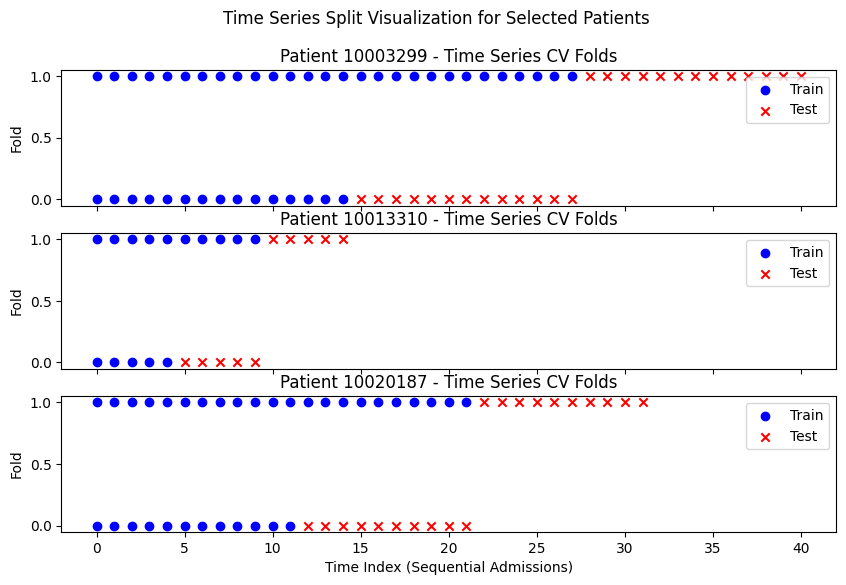

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

df = processed_df.copy()  # Replace with actual file path

# Convert `charttime` to datetime for correct time-based sorting
df["charttime"] = pd.to_datetime(df["charttime"])
# Sort data by patient and time
df = df.sort_values(by=["subject_id", "charttime"])

# Define features and target
features = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]
target = "Stroke_Y/N"

# Select a few example patients for visualization
example_patients = df["subject_id"].unique()[:3]  # Select first 3 patients

# Plot each patient’s fold splits
fig, axes = plt.subplots(len(example_patients), 1, figsize=(10, 6), sharex=True)

if len(example_patients) == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, subject_id in zip(axes, example_patients):
    group = df[df["subject_id"] == subject_id]
    X = group[features].values
    y = group[target].values

    # tscv = TimeSeriesSplit(n_splits=3)

    ax.set_title(f"Patient {subject_id} - Time Series CV Folds")

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        ax.scatter(train_idx, [fold] * len(train_idx), color="blue", marker="o", label="Train" if fold == 0 else "")
        ax.scatter(test_idx, [fold] * len(test_idx), color="red", marker="x", label="Test" if fold == 0 else "")

    ax.set_ylabel("Fold")
    ax.legend()

plt.xlabel("Time Index (Sequential Admissions)")
plt.suptitle("Time Series Split Visualization for Selected Patients")
plt.show()


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = processed_df.copy()  # Replace with actual file path

# Convert `charttime` to datetime for correct time-based sorting
df["charttime"] = pd.to_datetime(df["charttime"])

# Step 1: Sort by patient (`subject_id`) and time (`charttime`)
df = df.sort_values(by=["subject_id", "charttime"])

# Step 2: Get unique patient IDs
unique_patients = df["subject_id"].unique()

# Step 3: Split patients into train (60%), validation (20%), and test (20%)
train_patients, temp_patients = train_test_split(unique_patients, test_size=0.4, random_state=42)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

# Step 4: Assign train, validation, and test sets based on patient split
train_df = df[df["subject_id"].isin(train_patients)]
val_df = df[df["subject_id"].isin(val_patients)]
test_df = df[df["subject_id"].isin(test_patients)]

# Step 5: Ensure time-based splitting within each patient
def split_time_based(group):
    """Splits each patient's records into time-based train, val, and test sets."""
    total_visits = len(group)
    train_cutoff = int(total_visits * 0.6)
    val_cutoff = int(total_visits * 0.8)

    train = group.iloc[:train_cutoff]
    val = group.iloc[train_cutoff:val_cutoff]
    test = group.iloc[val_cutoff:]

    return train, val, test

# Apply time-based split to each patient group
train_df_list, val_df_list, test_df_list = [], [], []

for patient_id, group in df.groupby("subject_id"):
    train, val, test = split_time_based(group)
    train_df_list.append(train)
    val_df_list.append(val)
    test_df_list.append(test)

# Concatenate results
train_df = pd.concat(train_df_list)
val_df = pd.concat(val_df_list)
test_df = pd.concat(test_df_list)

# Step 6: Verify the split
print(f"Train set: {train_df.shape}, Validation set: {val_df.shape}, Test set: {test_df.shape}")
print(f"Train time range: {train_df['charttime'].min()} - {train_df['charttime'].max()}")
print(f"Validation time range: {val_df['charttime'].min()} - {val_df['charttime'].max()}")
print(f"Test time range: {test_df['charttime'].min()} - {test_df['charttime'].max()}")

# Step 7: Prepare ML datasets
X_train, y_train = train_df.drop(columns=["Stroke_Y/N"]), train_df["Stroke_Y/N"]
X_val, y_val = val_df.drop(columns=["Stroke_Y/N"]), val_df["Stroke_Y/N"]
X_test, y_test = test_df.drop(columns=["Stroke_Y/N"]), test_df["Stroke_Y/N"]



Train set: (40254, 22), Validation set: (13589, 22), Test set: (14124, 22)
Train time range: 2110-01-21 03:57:00 - 2212-01-19 16:36:00
Validation time range: 2110-07-01 03:41:00 - 2212-04-06 01:45:00
Test time range: 2110-07-01 04:51:00 - 2212-04-06 12:20:00


In [14]:
X_train

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,...,seq_num,icd_code,icd_version,icd_title,numeric_part,gender,anchor_age,anchor_year,anchor_year_group,dod
22,10003299,33780565,2178-12-10 18:19:00,NaN,58.0,18.0,97.0,149.0,71.0,Sinus Rhythm,...,1,5789,9,GASTROINTEST HEMORR NOS,5789,F,65,2173,2008 - 2010,2183-08-12
23,10003299,33780565,2178-12-10 19:28:00,98.4,68.0,17.0,97.0,121.0,65.0,NaN,...,1,5789,9,GASTROINTEST HEMORR NOS,5789,F,65,2173,2008 - 2010,2183-08-12
24,10003299,33780565,2178-12-10 21:11:00,98.5,60.0,18.0,98.0,149.0,63.0,NaN,...,1,5789,9,GASTROINTEST HEMORR NOS,5789,F,65,2173,2008 - 2010,2183-08-12
35,10003299,39680380,2179-06-30 09:41:00,NaN,59.0,15.0,97.0,141.0,65.0,NaN,...,1,43491,9,CEREBRAL ART OCCLUS W/INFARCT,43491,F,65,2173,2008 - 2010,2183-08-12
36,10003299,39680380,2179-06-30 09:41:00,NaN,59.0,15.0,97.0,141.0,65.0,NaN,...,2,72989,9,MUSCSKEL SYMPT LIMB NEC,72989,F,65,2173,2008 - 2010,2183-08-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67947,19992885,32628625,2152-06-20 07:21:00,NaN,77.0,NaN,97.0,124.0,63.0,NaN,...,3,4589,9,HYPOTENSION NOS,4589,M,50,2152,2014 - 2016,2152-07-24
67948,19992885,32628625,2152-06-20 08:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,99811,9,HEMORR COMPLIC PROCEDURE,99811,M,50,2152,2014 - 2016,2152-07-24
67949,19992885,32628625,2152-06-20 08:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,E8799,9,ABN REACT-PROCEDURE NOS,8799,M,50,2152,2014 - 2016,2152-07-24
67950,19992885,32628625,2152-06-20 08:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,4589,9,HYPOTENSION NOS,4589,M,50,2152,2014 - 2016,2152-07-24


In [ ]:
targets = processed_df['Stroke_Y/N']

temp = targets.value_counts()
temp

plt.figure(figsize=(6, 3))
plt.pie(temp, labels=temp.index, autopct="%.0f%%")
plt.title('Target distribution')
plt.show()

### Stratified Split
- First Split (80% train + 20% test)
- Second Split (80% train, 20% validation)


In [ ]:
y = processed_df["Stroke_Y/N"]
X = processed_df.drop(columns=["Stroke_Y/N"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
y

In [ ]:
# # Save X_test and y_test
# X_test.to_csv("X_test.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)

# # Save X_val and y_val
# X_val.to_csv("X_val.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

# print("Test and validation sets saved successfully.")


## Baseline Model Training

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Define models to evaluate
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naïve Bayes": GaussianNB(),
    # "SVC": SVC(kernel='rbf', probability=True, random_state=42),

}

# Define number of folds
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over models
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")

    f1_scores, precision_scores, recall_scores, accuracy_scores = [], [], [], []

    # Perform K-Fold Cross Validation
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train model
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)

        # Compute metrics
        f1_scores.append(f1_score(y_val, y_val_pred, average='weighted'))
        precision_scores.append(precision_score(y_val, y_val_pred, average='weighted'))
        recall_scores.append(recall_score(y_val, y_val_pred, average='weighted'))
        accuracy_scores.append(accuracy_score(y_val, y_val_pred))

    # Print average performance for this model
    print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
    print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
    print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")


### SHAP and LIME Analysis

#### SHAP

In [ ]:
#  create a SHAP explainer and calculate SHAP values for the test set
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)


In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test)


##### Summary Plot Insights

Notes:

**Observations**


**Key Takeaway**


In [ ]:
X_test

##### Dependence Plot Insights

Notes:


**Observations**


**Key Takeaway**



#### LIME

In [ ]:
# lime_explanation = explainer_lime.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=10)
# lime_explanation.as_pyplot_figure()
# plt.show()

##### Insights
**Observations**



**Key Takeaway**


### Model Tracking With MLFlow

In [ ]:
!pip install -q mlflow pyngrok

In [ ]:
import mlflow
from pyngrok import ngrok

# Start MLflow tracking server
get_ipython().system_raw("mlflow server --host 0.0.0.0 --port 8081 --backend-store-uri sqlite:///mlflow.db &")

# Expose the MLflow tracking server
public_url = ngrok.connect(8081).public_url
print(f"MLflow Tracking UI: {public_url}")

# Set MLflow tracking URI
mlflow.set_tracking_uri(public_url)

# Set Experiment
mlflow.set_experiment("Stroke Prediction Experiment")


In [ ]:
train_data = X_train.copy()
train_data['category'] = y_train

val_data = X_val.copy()
val_data['category'] = y_val

test_data = X_test.copy()
test_data['category'] = y_test

In [ ]:
train_df = mlflow.data.from_pandas(train_data, source=preprocessed_data_path)
val_df = mlflow.data.from_pandas(val_data, source=preprocessed_data_path)
test_df = mlflow.data.from_pandas(test_data, source=preprocessed_data_path)

In [ ]:
# logging with MLflow

data_source_path = "preprocessed_data.csv"

with mlflow.start_run():

    # log the dataset used
    mlflow.log_input(train_df, context='training')
    mlflow.log_input(val_df, context='validation')
    mlflow.log_input(test_df, context='testing')

    #log artifacts, no parameters to log yet
    mlflow.log_artifact(data_source_path, artifact_path="model_data")


    # log tags
    mlflow.set_tags({
        "model_type": "RandomForest",
        "framework": "sklearn",
        "experiment_name": "Model_Experiment",
        "random_state": "42"
    })

    # log parameter source code
    mlflow.log_param("source_code", "train_model.py")  # Replace with your actual script/file

    # log model
    mlflow.sklearn.log_model(model, "model")

    # log metrics
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("test_f1", test_f1)

    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("test_precision", test_precision)

    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("test_recall", test_recall)

    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)